In [1]:
from kaggle_secrets import UserSecretsClient
secret_label = "Token"
token = UserSecretsClient().get_secret(secret_label)

! git clone https://{token}@github.com/FrancescoZanella/RecSysChallenge2024.git

Cloning into 'RecSysChallenge2024'...
remote: Enumerating objects: 1048, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 1048 (delta 14), reused 14 (delta 12), pack-reused 1024
Receiving objects: 100% (1048/1048), 31.70 MiB | 25.09 MiB/s, done.
Resolving deltas: 100% (510/510), done.


In [2]:
%cd /kaggle/working/RecSysChallenge2024/src

/kaggle/working/RecSysChallenge2024/src


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import polars as pl
import scipy.stats as stats
import scipy.sparse as sps
import gc
import tqdm

from ebrec.utils._descriptive_analysis import (
    min_max_impression_time_behaviors, 
    min_max_impression_time_history
)
from ebrec.utils._polars import slice_join_dataframes
from ebrec.utils._behaviors import (
    create_binary_labels_column,
    sampling_strategy_wu2019,
    truncate_history,
)
from ebrec.utils._constants import (
    DEFAULT_HISTORY_ARTICLE_ID_COL,
    DEFAULT_CLICKED_ARTICLES_COL,
    DEFAULT_INVIEW_ARTICLES_COL,
    DEFAULT_USER_COL
)
from ebrec.evaluation.metrics_protocols import *
from polimi.utils._catboost import add_trendiness_feature, add_mean_delays_features,add_history_trendiness_scores_feature

from catboost import CatBoostClassifier

2024-04-09 22:25:42.716547: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-09 22:25:42.716818: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-09 22:25:42.891011: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Memory Utils

In [4]:
from os import system, getpid, walk
from psutil import Process
from colorama import Fore, Style, init
from IPython.display import display, HTML

def PrintColor(text:str, color = Fore.BLUE, style = Style.BRIGHT):
    print(style + color + text + Style.RESET_ALL)
    
def GetMemUsage():   
    pid = getpid()
    py = Process(pid)
    memory_use = py.memory_info()[0] / 2. ** 30
    return f"RAM memory GB usage = {memory_use :.4}"

PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)


RAM memory GB usage = 0.8452


In [5]:
def reduce_polars_df_memory_size(df, set_categorical=True):

    start_mem = df.estimated_size('mb')
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type in [pl.Int16, pl.Int32, pl.Int64]:
            c_min = df[col].fill_null(0).min()
            c_max = df[col].fill_null(0).max()
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df = df.with_columns(pl.col(col).cast(pl.Int8))
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df = df.with_columns(pl.col(col).cast(pl.Int16))
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df = df.with_columns(pl.col(col).cast(pl.Int32))
        elif col_type in [pl.UInt16, pl.UInt32, pl.UInt64]:
            c_min = df[col].fill_null(0).min()
            c_max = df[col].fill_null(0).max()
            if c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                df = df.with_columns(pl.col(col).cast(pl.UInt8))
            elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                df = df.with_columns(pl.col(col).cast(pl.UInt16))
            elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                df = df.with_columns(pl.col(col).cast(pl.UInt32))
        elif col_type == pl.Float64:
            c_min = df[col].fill_null(0).min()
            c_max = df[col].fill_null(0).max()
            if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df = df.with_columns(pl.col(col).cast(pl.Float32))

    gc.collect()
    end_mem = df.estimated_size('mb')
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

# Data import

In [6]:
articles = pl.read_parquet('/kaggle/input/recommender-systems-challenge-2024/ebnerd_small/articles.parquet')

behaviors_train = pl.read_parquet('/kaggle/input/recommender-systems-challenge-2024/ebnerd_small/train/behaviors.parquet')
history_train = pl.read_parquet('/kaggle/input/recommender-systems-challenge-2024/ebnerd_small/train/history.parquet')

behaviors_val = pl.read_parquet('/kaggle/input/recommender-systems-challenge-2024/ebnerd_small/validation/behaviors.parquet')
history_val = pl.read_parquet('/kaggle/input/recommender-systems-challenge-2024/ebnerd_small/validation/history.parquet')

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)


RAM memory GB usage = 1.102


# Articles Preprocessing

In [7]:
articles = articles.with_columns(
    pl.col('image_ids').list.len().alias('num_images'),
    pl.col('title').str.split(by=' ').list.len().alias('title_len'),
    pl.col('subtitle').str.split(by=' ').list.len().alias('subtitle_len'),
    pl.col('body').str.split(by=' ').list.len().alias('body_len'),
    # very important for tf-idf, otherwise multiple tokens for topics with spaces are built
    pl.col('topics').list.eval(pl.element().str.split(by=' ').list.join('_')) 
)
articles = reduce_polars_df_memory_size(articles)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
articles.head(2)

Memory usage of dataframe is 64.11 MB
Memory usage after optimization is: 63.96 MB
Decreased by 0.2%

RAM memory GB usage = 1.109


article_id,title,subtitle,last_modified_time,premium,body,published_time,image_ids,article_type,url,ner_clusters,entity_groups,topics,category,subcategory,category_str,total_inviews,total_pageviews,total_read_time,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len
i32,str,str,datetime[μs],bool,str,datetime[μs],list[i64],str,str,list[str],list[str],list[str],i16,list[i16],str,i32,i32,f32,f32,str,u32,u8,u8,u16
3001353,"""Natascha var i…","""Politiet frygt…",2023-06-29 06:20:33,false,"""Sagen om den ø…",2006-08-31 08:06:45,[3150850],"""article_defaul…","""https://ekstra…",[],[],"[""Kriminalitet"", ""Personfarlig_kriminalitet""]",140,[],"""krimi""",null,null,null,0.9955,"""Negative""",1,5,22,200
3003065,"""Kun Star Wars …","""Biografgængern…",2023-06-29 06:20:35,false,"""Vatikanet har …",2006-05-21 16:57:00,[3006712],"""article_defaul…","""https://ekstra…",[],[],"[""Underholdning"", ""Film_og_tv"", ""Økonomi""]",414,"[433, 434]","""underholdning""",null,null,null,0.846,"""Positive""",1,5,19,116


In [8]:
unique_entities = articles.select('entity_groups').explode('entity_groups')['entity_groups'].unique().to_list()
unique_entities = [e for e in unique_entities if e is not None]
unique_entities

['EVENT', 'ORG', 'LOC', 'PER', 'PROD', 'MISC']

In [9]:
# in case of two category_str for the same category, one of the two is picked
unique_categories_df = articles.select(['category', 'category_str']).unique('category').drop_nulls('category')
unique_categories = {
    row['category']: row['category_str'] for row in unique_categories_df.iter_rows(named=True)
}
unique_categories

{572: 'side9',
 2504: 'bibliotek',
 539: 'ferie',
 414: 'underholdning',
 2975: 'penge',
 140: 'krimi',
 1505: 'vin',
 457: 'forbrug',
 561: 'haandvaerkeren',
 22: 'horoskoper',
 2731: 'dagsorden',
 498: 'musik',
 2889: 'auto',
 2737: 'podcast',
 2341: 'plus',
 731: 'services',
 142: 'sport',
 2: 'incoming',
 529: 'biler',
 806: 'om_ekstra_bladet',
 2077: 'opinionen',
 118: 'nyheder',
 68: 'video',
 512: 'nationen',
 565: 'sex_og_samliv'}

Mapping sentiment labels to -1, 0, 1 to save memory in the history dataframe.
Taking only article_default type and mapping it to 0/1 since after only this is needed (and it saves memory) for the history at the moment

In [10]:
articles = articles.with_columns(
    pl.when(pl.col('sentiment_label') == 'Negative').then(-1) \
        .otherwise(
            pl.when(pl.col('sentiment_label') == 'Positive').then(1).otherwise(0)
        ).cast(pl.Int8).alias('sentiment_label_int'),
    (pl.col('article_type') == 'article_default').cast(pl.UInt8).alias('is_article_default')
)

## Topics TF-IDF

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
articles = articles.with_columns(
    pl.Series(
        vectorizer.fit_transform(
            articles.with_columns(pl.col('topics').list.join(separator=' '))['topics'].to_list()
        ).toarray().astype(np.float32)
    ).alias('topics_idf')
)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
articles.head(2)


RAM memory GB usage = 1.124


article_id,title,subtitle,last_modified_time,premium,body,published_time,image_ids,article_type,url,ner_clusters,entity_groups,topics,category,subcategory,category_str,total_inviews,total_pageviews,total_read_time,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,sentiment_label_int,is_article_default,topics_idf
i32,str,str,datetime[μs],bool,str,datetime[μs],list[i64],str,str,list[str],list[str],list[str],i16,list[i16],str,i32,i32,f32,f32,str,u32,u8,u8,u16,i8,u8,list[f32]
3001353,"""Natascha var i…","""Politiet frygt…",2023-06-29 06:20:33,false,"""Sagen om den ø…",2006-08-31 08:06:45,[3150850],"""article_defaul…","""https://ekstra…",[],[],"[""Kriminalitet"", ""Personfarlig_kriminalitet""]",140,[],"""krimi""",null,null,null,0.9955,"""Negative""",1,5,22,200,-1,1,"[0.0, 0.0, … 0.0]"
3003065,"""Kun Star Wars …","""Biografgængern…",2023-06-29 06:20:35,false,"""Vatikanet har …",2006-05-21 16:57:00,[3006712],"""article_defaul…","""https://ekstra…",[],[],"[""Underholdning"", ""Film_og_tv"", ""Økonomi""]",414,"[433, 434]","""underholdning""",null,null,null,0.846,"""Positive""",1,5,19,116,1,1,"[0.0, 0.0, … 0.536059]"


In [12]:
# without split + join with _ of the single topics this returns 94
len(vectorizer.get_feature_names_out())

79

## Topic Model

In [13]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer

stopwords = nltk.corpus.stopwords.words('danish')
title_vectorizer = CountVectorizer(stop_words=stopwords)

titles_bow = title_vectorizer.fit_transform(articles['title'].to_list())

In [14]:
%%time

from sklearn.decomposition import LatentDirichletAllocation

# parameters tuned on perplexity
N_COMPONENTS = 5
lda_model = LatentDirichletAllocation(
    n_components=N_COMPONENTS,
    doc_topic_prior=0.99,
    topic_word_prior=0.75,
    learning_method='online'
)
articles = articles.with_columns(
    pl.Series(lda_model.fit_transform(titles_bow).astype(np.float32)) \
        .list.to_array(5).alias('topic_model_embeddings')
)
articles.head(2)

CPU times: user 35.4 s, sys: 0 ns, total: 35.4 s
Wall time: 35.5 s


article_id,title,subtitle,last_modified_time,premium,body,published_time,image_ids,article_type,url,ner_clusters,entity_groups,topics,category,subcategory,category_str,total_inviews,total_pageviews,total_read_time,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,sentiment_label_int,is_article_default,topics_idf,topic_model_embeddings
i32,str,str,datetime[μs],bool,str,datetime[μs],list[i64],str,str,list[str],list[str],list[str],i16,list[i16],str,i32,i32,f32,f32,str,u32,u8,u8,u16,i8,u8,list[f32],"array[f32, 5]"
3001353,"""Natascha var i…","""Politiet frygt…",2023-06-29 06:20:33,false,"""Sagen om den ø…",2006-08-31 08:06:45,[3150850],"""article_defaul…","""https://ekstra…",[],[],"[""Kriminalitet"", ""Personfarlig_kriminalitet""]",140,[],"""krimi""",null,null,null,0.9955,"""Negative""",1,5,22,200,-1,1,"[0.0, 0.0, … 0.0]","[0.281153, 0.14361, … 0.143801]"
3003065,"""Kun Star Wars …","""Biografgængern…",2023-06-29 06:20:35,false,"""Vatikanet har …",2006-05-21 16:57:00,[3006712],"""article_defaul…","""https://ekstra…",[],[],"[""Underholdning"", ""Film_og_tv"", ""Økonomi""]",414,"[433, 434]","""underholdning""",null,null,null,0.846,"""Positive""",1,5,19,116,1,1,"[0.0, 0.0, … 0.536059]","[0.116234, 0.109821, … 0.226648]"


In [15]:
topic_model_columns = [f'topic_model_embedding_{i}' for i in range(N_COMPONENTS)]

articles = articles.with_columns(
    pl.col('topic_model_embeddings').arr.to_struct(fields=lambda i: f'topic_model_embedding_{i}')
).with_columns([
    pl.col('topic_model_embeddings').struct.field(f'topic_model_embedding_{i}') for i in range(N_COMPONENTS)
]).drop('topic_model_embeddings')

articles.head(2)

article_id,title,subtitle,last_modified_time,premium,body,published_time,image_ids,article_type,url,ner_clusters,entity_groups,topics,category,subcategory,category_str,total_inviews,total_pageviews,total_read_time,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,sentiment_label_int,is_article_default,topics_idf,topic_model_embedding_0,topic_model_embedding_1,topic_model_embedding_2,topic_model_embedding_3,topic_model_embedding_4
i32,str,str,datetime[μs],bool,str,datetime[μs],list[i64],str,str,list[str],list[str],list[str],i16,list[i16],str,i32,i32,f32,f32,str,u32,u8,u8,u16,i8,u8,list[f32],f32,f32,f32,f32,f32
3001353,"""Natascha var i…","""Politiet frygt…",2023-06-29 06:20:33,false,"""Sagen om den ø…",2006-08-31 08:06:45,[3150850],"""article_defaul…","""https://ekstra…",[],[],"[""Kriminalitet"", ""Personfarlig_kriminalitet""]",140,[],"""krimi""",null,null,null,0.9955,"""Negative""",1,5,22,200,-1,1,"[0.0, 0.0, … 0.0]",0.281153,0.14361,0.143919,0.287517,0.143801
3003065,"""Kun Star Wars …","""Biografgængern…",2023-06-29 06:20:35,false,"""Vatikanet har …",2006-05-21 16:57:00,[3006712],"""article_defaul…","""https://ekstra…",[],[],"[""Underholdning"", ""Film_og_tv"", ""Økonomi""]",414,"[433, 434]","""underholdning""",null,null,null,0.846,"""Positive""",1,5,19,116,1,1,"[0.0, 0.0, … 0.536059]",0.116234,0.109821,0.313377,0.23392,0.226648


# History preprocessing

In [16]:
def add_topics_tf_idf_columns(df, topics_col, vectorizer):
    return df.with_columns(
        pl.Series(
            vectorizer.transform(
                df.with_columns(pl.col(topics_col).list.join(separator=' '))[topics_col].to_list()
            ).toarray().astype(np.float32)
        ).alias(f'{topics_col}_tf_idf')
    )

In [17]:
%%time

STRONG_THR = 0.8

history_train = pl.concat(
    rows.with_columns(pl.col('article_id_fixed').list.len().alias('NumArticlesHistory')) \
        .explode(['article_id_fixed', 'impression_time_fixed', 'read_time_fixed', 'scroll_percentage_fixed']) \
        .sort(by=['user_id', 'impression_time_fixed']) \
        .with_columns(
            pl.col('impression_time_fixed').dt.weekday().alias('weekday'),
            pl.col('impression_time_fixed').dt.hour().alias('hour'),
        ).join(articles.select(['article_id', 'category', 'is_article_default', 'sentiment_label_int', 
                                'sentiment_score', 'entity_groups', 'topics']), 
               left_on='article_id_fixed', right_on='article_id', how='left') \
        .with_columns(
            (pl.col('sentiment_label_int') == 0).alias('is_neutral'),
            (pl.col('sentiment_label_int') == 1).alias('is_positive'),
            (pl.col('sentiment_label_int') == -1).alias('is_negative'),
            ((pl.col('sentiment_label_int') == 0) & (pl.col('sentiment_score') > STRONG_THR)).alias('strong_neutral'),
            ((pl.col('sentiment_label_int') == 1) & (pl.col('sentiment_score') > STRONG_THR)).alias('strong_positive'),
            ((pl.col('sentiment_label_int') == -1) & (pl.col('sentiment_score') > STRONG_THR)).alias('strong_negative'),
            pl.col('entity_groups').list.unique(),
        ).group_by('user_id').agg(
            pl.col('article_id_fixed'),
            pl.col('impression_time_fixed'),
            pl.col('category'),
            pl.col('NumArticlesHistory').first(),
            pl.col('read_time_fixed').median().alias('MedianReadTime'),
            pl.col('read_time_fixed').max().alias('MaxReadTime'),
            pl.col('read_time_fixed').sum().alias('TotalReadTime'),
            pl.col('scroll_percentage_fixed').median().alias('MedianScrollPercentage'),
            pl.col('scroll_percentage_fixed').max().alias('MaxScrollPercentage'),
            (pl.col('is_neutral').sum() / pl.col('NumArticlesHistory').first()).alias('NeutralPct'),
            (pl.col('is_positive').sum() / pl.col('NumArticlesHistory').first()).alias('PositivePct'),
            (pl.col('is_negative').sum() / pl.col('NumArticlesHistory').first()).alias('NegativePct'),
            (pl.col('strong_neutral').sum() / pl.col('NumArticlesHistory').first()).alias('PctStrongNeutral'),
            (pl.col('strong_positive').sum() / pl.col('NumArticlesHistory').first()).alias('PctStrongPositive'),
            (pl.col('strong_negative').sum() / pl.col('NumArticlesHistory').first()).alias('PctStrongNegative'),
            (1 - (pl.col('is_article_default').sum() / pl.col('NumArticlesHistory').first())).alias('PctNotDefaultArticles'),
            pl.col('category').mode().alias('MostFrequentCategory'),
            pl.col('weekday').mode().alias('MostFrequentWeekday'),
            pl.col('hour').mode().alias('MostFrequentHour'),
            pl.col('entity_groups').flatten(),
            pl.col('topics').flatten().alias('topics_flatten')
        ).pipe(add_topics_tf_idf_columns, topics_col='topics_flatten', vectorizer=vectorizer) \
        .drop('topics_flatten').with_columns(
            pl.col('MostFrequentCategory').list.first(),
            pl.col('MostFrequentWeekday').list.first(),
            pl.col('MostFrequentHour').list.first(),
        ).with_columns(
            (pl.col('entity_groups').list.count_matches(entity) / pl.col('NumArticlesHistory')).alias(f'{entity}Pct')
            for entity in unique_entities
        ).drop('entity_groups')
    for rows in tqdm.tqdm(history_train.iter_slices(1000), total=history_train.shape[0] // 1000)
)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
history_train = reduce_polars_df_memory_size(history_train)
history_train.head(2)

16it [00:17,  1.12s/it]                        



RAM memory GB usage = 1.234
Memory usage of dataframe is 39.39 MB
Memory usage after optimization is: 38.61 MB
Decreased by 2.0%
CPU times: user 20.6 s, sys: 1.93 s, total: 22.5 s
Wall time: 18.7 s


user_id,article_id_fixed,impression_time_fixed,category,NumArticlesHistory,MedianReadTime,MaxReadTime,TotalReadTime,MedianScrollPercentage,MaxScrollPercentage,NeutralPct,PositivePct,NegativePct,PctStrongNeutral,PctStrongPositive,PctStrongNegative,PctNotDefaultArticles,MostFrequentCategory,MostFrequentWeekday,MostFrequentHour,topics_flatten_tf_idf,EVENTPct,ORGPct,LOCPct,PERPct,PRODPct,MISCPct
u32,list[i32],list[datetime[μs]],list[i16],u16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i8,i8,list[f32],f32,f32,f32,f32,f32,f32
10623,"[9739035, 9739065, … 9770533]","[2023-04-27 14:29:44, 2023-04-27 14:29:47, … 2023-05-17 17:36:24]","[118, 414, … 140]",143,3.0,1563.0,9623.0,42.5,100.0,0.230769,0.111888,0.657343,0.097902,0.083916,0.608392,0.06993,118,3,16,"[0.016041, 0.062928, … 0.178427]",0.202797,0.888112,0.804196,0.874126,0.237762,0.223776
12016,"[9738216, 9735383, … 9769622]","[2023-04-27 07:39:48, 2023-04-27 07:41:30, … 2023-05-17 23:56:30]","[140, 118, … 140]",264,156.0,1775.0,63672.0,100.0,100.0,0.257576,0.075758,0.666667,0.106061,0.034091,0.602273,0.07197,140,5,20,"[0.009749, 0.045896, … 0.075912]",0.087121,0.852273,0.776515,0.787879,0.318182,0.117424


In [18]:
history_train.shape

(15143, 27)

# Named entity collaborative filtering

In [19]:
user_id_mapping = history_train.sort('user_id').with_row_index() \
    .select(['index', 'user_id']).rename({'index': 'user_index'})

ner_mapping = articles.select(['ner_clusters']) \
    .explode('ner_clusters') \
    .rename({'ner_clusters': 'ner'}) \
    .with_columns(pl.col('ner').str.strip_chars_start('\" ').str.to_lowercase()) \
    .unique('ner').drop_nulls().filter(pl.col('ner').str.len_chars() > 0) \
    .sort('ner').with_row_index().rename({'index': 'ner_index'})

In [20]:
ner_interactions = history_train.select(['user_id', 'article_id_fixed']).explode('article_id_fixed') \
    .join(articles.select(['article_id', 'ner_clusters']), left_on='article_id_fixed', right_on='article_id', how='left') \
    .explode('ner_clusters').unique(['user_id', 'ner_clusters']) \
    .with_columns(pl.col('ner_clusters').str.strip_chars_start('\" ').str.to_lowercase()) \
    .join(user_id_mapping, on='user_id', how='left') \
    .join(ner_mapping, left_on='ner_clusters', right_on='ner') \
    .select(['user_index', 'ner_index', 'user_id', 'article_id_fixed']) \
    .unique(['user_index', 'ner_index'])

URM_ner = sps.csr_matrix((np.ones(ner_interactions.shape[0]),
                          (ner_interactions['user_index'].to_numpy(), ner_interactions['ner_index'].to_numpy())),
                         shape=(user_id_mapping.shape[0], ner_mapping.shape[0]))

ner_interactions_test = behaviors_train.select(['user_id', 'article_ids_clicked']).explode('article_ids_clicked') \
    .join(articles.select(['article_id', 'ner_clusters']), left_on='article_ids_clicked', right_on='article_id', how='left') \
    .explode('ner_clusters').unique(['user_id', 'ner_clusters']) \
    .with_columns(pl.col('ner_clusters').str.strip_chars_start('\" ').str.to_lowercase()) \
    .join(user_id_mapping, on='user_id', how='left') \
    .join(ner_mapping, left_on='ner_clusters', right_on='ner') \
    .select(['user_index', 'ner_index', 'user_id', 'article_ids_clicked']) \
    .unique(['user_index', 'ner_index'])

URM_ner_test = sps.csr_matrix((np.ones(ner_interactions_test.shape[0]),
                               (ner_interactions_test['user_index'].to_numpy(), ner_interactions_test['ner_index'].to_numpy())),
                              shape=(user_id_mapping.shape[0], ner_mapping.shape[0]))

In [21]:
%cd /kaggle/working
! git clone https://github.com/MaurizioFD/RecSys_Course_AT_PoliMi.git

/kaggle/working


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Cloning into 'RecSys_Course_AT_PoliMi'...
remote: Enumerating objects: 1519, done.
remote: Counting objects: 100% (255/255), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 1519 (delta 223), reused 220 (delta 212), pack-reused 1264
Receiving objects: 100% (1519/1519), 50.33 MiB | 25.28 MiB/s, done.
Resolving deltas: 100% (909/909), done.


In [22]:
%cd /kaggle/working/RecSys_Course_AT_PoliMi

from Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender
from Evaluation.Evaluator import EvaluatorHoldout

np.int = int
np.random.seed(42)
np.bool = bool
np.float = float

item_knn = ItemKNNCFRecommender(URM_ner)
item_knn.fit(topK=100, similarity='jaccard')

evaluator = EvaluatorHoldout(URM_ner_test, cutoff_list=[10], exclude_seen=False)
result_df, _ = evaluator.evaluateRecommender(item_knn)
result_df

/kaggle/working/RecSys_Course_AT_PoliMi
ItemKNNCFRecommender: URM Detected 1 ( 0.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 18909 (43.2%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 43774 (100.0%), 158.77 column/sec. Elapsed time 4.59 min
EvaluatorHoldout: Ignoring 31 ( 0.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 15112 (100.0%) in 45.68 sec. Users per second: 331


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.311971,0.312913,0.030088,0.214433,0.214676,0.469902,0.319612,0.054883,0.766609,0.953152,...,0.997953,0.76504,0.997953,0.002086,5.362616,0.952586,0.016842,0.419597,3.357942,0.009295


In [23]:
pure_svd = PureSVDRecommender(URM_ner)
pure_svd.fit(num_factors=20)

result_df, _ = evaluator.evaluateRecommender(pure_svd)
result_df

PureSVDRecommender: URM Detected 1 ( 0.0%) users with no interactions.
PureSVDRecommender: URM Detected 18909 (43.2%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 4.82 sec
EvaluatorHoldout: Processed 15112 (100.0%) in 24.22 sec. Users per second: 624


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.342628,0.345141,0.048661,0.261759,0.263204,0.670397,0.392258,0.085219,0.858655,1.275579,...,0.997953,0.856898,0.997953,0.001871,5.929536,0.95823,0.015104,0.463956,3.324192,0.009294


In [24]:
%%time

def get_inview_scores(user_ners_df, recommender, f_name):
    user_index = user_ners_df['user_index'].to_list()[0]
    ners = user_ners_df['ner_index'].to_numpy()
    scores = recommender._compute_item_score([user_index], ners)[0, ners]
    return user_ners_df.with_columns(
        pl.Series(scores).alias(f_name)
    )

ner_inview_scores = behaviors_train.select(['user_id', 'article_ids_inview']).explode('article_ids_inview') \
    .join(articles.select(['article_id', 'ner_clusters']), left_on='article_ids_inview', right_on='article_id', how='left') \
    .explode('ner_clusters').unique(['user_id', 'ner_clusters']) \
    .with_columns(pl.col('ner_clusters').str.strip_chars_start('\" ').str.to_lowercase()) \
    .join(user_id_mapping, on='user_id', how='left') \
    .join(ner_mapping, left_on='ner_clusters', right_on='ner') \
    .select(['user_index', 'ner_index', 'user_id', 'article_ids_inview']) \
    .unique(['user_index', 'ner_index']) \
    .sort(['user_index', 'ner_index']).group_by('user_index').map_groups(
        lambda user_df: user_df.pipe(get_inview_scores, recommender=pure_svd, f_name='pure_svd_scores') \
            .pipe(get_inview_scores, recommender=item_knn, f_name='item_knn_scores')
    )

behaviors_ner_scores = behaviors_train.select(['impression_id', 'user_id', 'article_ids_inview']).explode('article_ids_inview') \
    .join(ner_inview_scores, on=['user_id', 'article_ids_inview'], how='left') \
    .with_columns(pl.col(['pure_svd_scores', 'item_knn_scores']).fill_null(0)) \
    .group_by(['impression_id', 'article_ids_inview']).agg(
        pl.col('pure_svd_scores').sum().alias('total_ner_svd_scores'),
        pl.col('pure_svd_scores').mean().alias('mean_ner_svd_scores'),
        pl.col('pure_svd_scores').max().alias('max_ner_svd_scores'),
        pl.col('item_knn_scores').sum().alias('total_ner_item_knn_scores'),
        pl.col('item_knn_scores').mean().alias('mean_ner_item_knn_scores'),
        pl.col('item_knn_scores').max().alias('max_ner_item_knn_scores'),
    ).with_columns(
        pl.col(['total_ner_svd_scores', 'mean_ner_svd_scores', 
                'total_ner_item_knn_scores', 'mean_ner_item_knn_scores',
                'max_ner_svd_scores', 'max_ner_item_knn_scores']).max().over('impression_id').name.suffix('_max')
    ).with_columns(
        # l1 normalization
        pl.col('total_ner_svd_scores').truediv(pl.col('total_ner_svd_scores_max')),
        pl.col('mean_ner_svd_scores').truediv(pl.col('mean_ner_svd_scores_max')),
        pl.col('max_ner_svd_scores').truediv(pl.col('max_ner_svd_scores_max')),
        pl.col('total_ner_item_knn_scores').truediv(pl.col('total_ner_item_knn_scores_max')),
        pl.col('mean_ner_item_knn_scores').truediv(pl.col('mean_ner_item_knn_scores_max')),
        pl.col('max_ner_item_knn_scores').truediv(pl.col('max_ner_item_knn_scores_max')),
    ).drop(['total_ner_svd_scores_max', 'mean_ner_svd_scores_max', 
            'max_ner_svd_scores_max', 'total_ner_item_knn_scores_max',
            'mean_ner_item_knn_scores_max', 'max_ner_item_knn_scores_max']) \
    .rename({'article_ids_inview': 'article'})
behaviors_ner_scores.head(5)

CPU times: user 4min 33s, sys: 3min 11s, total: 7min 44s
Wall time: 2min 6s


impression_id,article,total_ner_svd_scores,mean_ner_svd_scores,max_ner_svd_scores,total_ner_item_knn_scores,mean_ner_item_knn_scores,max_ner_item_knn_scores
u32,i32,f32,f32,f32,f32,f32,f32
149474,9778623,0.168532,0.142604,0.963358,0.141152,0.119436,0.954842
149474,9778682,0.003561,0.004353,0.020612,0.023858,0.02916,0.164431
153068,9778657,1.0,1.0,0.898774,1.0,1.0,1.0
153068,9778682,0.078336,0.111909,0.434112,0.028487,0.040695,0.220174
153070,9525589,1.0,1.0,0.923632,0.867993,1.0,0.915791


In [25]:
del URM_ner
del URM_ner_test
del ner_inview_scores
del ner_interactions
del ner_interactions_test
gc.collect()

0

# Creating Training Dataframe

In [26]:
%%time

NPRATIO = 2

# dropping duplicates that can occur because of sampling strategy
train_ds = behaviors_train.pipe(sampling_strategy_wu2019, npratio=NPRATIO, shuffle=False, 
                                with_replacement=True, seed=123) \
    .pipe(create_binary_labels_column, shuffle=True, seed=123) \
    .with_columns(pl.col('gender').fill_null(2)) \
    .select(['impression_id', 'article_ids_inview', 'impression_time', 'labels', 
             'device_type', 'read_time', 'scroll_percentage', 'user_id', 'is_sso_user', 'gender',
             'age', 'is_subscriber', 'session_id']) \
    .explode(['article_ids_inview', 'labels']) \
    .rename({'article_ids_inview': 'article', 'labels': 'target'}) \
    .with_columns(pl.col('article').cast(pl.Int32)) \
    .pipe(add_mean_delays_features, articles=articles, history=history_train) \
    .pipe(add_trendiness_feature, articles=articles, period='3d') \
    .pipe(add_history_trendiness_scores_feature, history=history_train, articles=articles) \
    .unique(['impression_id', 'article']) \
    .with_columns(
        pl.col('impression_time').dt.weekday().alias('weekday'),
        pl.col('impression_time').dt.hour().alias('hour'),
        pl.col('article').cast(pl.Int32),
    ).join(articles.select(['article_id', 'premium', 'published_time', 'category',
                            'sentiment_score', 'sentiment_label', 'entity_groups',
                            'num_images', 'title_len', 'subtitle_len', 'body_len']),
           left_on='article', right_on='article_id', how='left') \
    .with_columns(
        (pl.col('impression_time') - pl.col('published_time')).dt.total_days().alias('article_delay_days'),
        (pl.col('impression_time') - pl.col('published_time')).dt.total_hours().alias('article_delay_hours')
    ).with_columns(
        pl.col('entity_groups').list.contains(entity).alias(f'Entity_{entity}_Present')
        for entity in unique_entities
    ).drop('entity_groups') \
    .join(behaviors_ner_scores, on=['impression_id', 'article'], how='left')

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)

train_ds = reduce_polars_df_memory_size(train_ds)
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
train_ds.head()


RAM memory GB usage = 1.874
Memory usage of dataframe is 115.91 MB
Memory usage after optimization is: 89.23 MB
Decreased by 23.0%

RAM memory GB usage = 1.882
CPU times: user 4min 41s, sys: 12.7 s, total: 4min 54s
Wall time: 1min 29s


impression_id,article,user_id,impression_time,target,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,session_id,mean_topics_mean_delay_days,mean_topics_mean_delay_hours,user_mean_delay_days,user_mean_delay_hours,trendiness_score,mean_user_trendiness_score,mean_topics_trendiness_score,weekday,hour,premium,published_time,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,article_delay_days,article_delay_hours,Entity_EVENT_Present,Entity_ORG_Present,Entity_LOC_Present,Entity_PER_Present,Entity_PROD_Present,Entity_MISC_Present,total_ner_svd_scores,mean_ner_svd_scores,max_ner_svd_scores,total_ner_item_knn_scores,mean_ner_item_knn_scores,max_ner_item_knn_scores
u32,i32,u32,datetime[μs],i8,i8,f32,f32,bool,i8,i8,bool,u32,f32,f32,f32,f32,i16,f32,f32,i8,i8,bool,datetime[μs],i16,f32,str,u32,u8,u8,u16,i16,i32,bool,bool,bool,bool,bool,bool,f32,f32,f32,f32,f32,f32
153068,9778682,151570,2023-05-24 07:09:04,0,1,78.0,100.0,false,2,null,false,1976,10.621649,257.855042,1.484877,37.41399,206,250.755203,295.832001,3,7,false,2023-05-24 06:32:42,498,0.9546,"""Negative""",1,5,20,267,0,0,true,true,false,true,true,false,0.078336,0.111909,0.434112,0.028487,0.040695,0.220174
153071,9775990,151570,2023-05-24 07:11:08,0,1,125.0,100.0,false,2,null,false,1976,3.884327,95.635483,1.484877,37.41399,465,250.755203,388.498718,3,7,false,2023-05-22 11:48:18,142,0.5539,"""Neutral""",1,4,20,382,1,43,true,true,true,true,false,true,0.441395,0.481522,0.964424,0.337171,0.367823,0.560344
153071,9771223,151570,2023-05-24 07:11:08,0,1,125.0,100.0,false,2,null,false,1976,3.884327,95.635483,1.484877,37.41399,465,250.755203,388.498718,3,7,false,2023-05-18 11:16:19,142,0.7164,"""Neutral""",1,6,31,206,5,139,true,true,true,true,true,true,0.441564,0.441564,0.706458,0.555869,0.555869,0.991501
155587,9778375,161621,2023-05-24 07:56:30,1,1,50.0,100.0,false,2,null,false,3625,6.949092,169.176773,6.861461,169.377838,189,194.843826,158.646133,3,7,false,2023-05-23 22:16:14,118,0.9979,"""Negative""",0,10,18,296,0,9,false,true,true,false,false,false,0.363022,0.944532,0.803921,0.369391,0.884181,0.963914
156066,9778701,163208,2023-05-24 07:12:03,0,2,10.0,null,false,2,null,false,3818,5.221263,128.023224,0.103448,4.342175,403,203.960205,303.974365,3,7,false,2023-05-24 07:00:39,142,0.582,"""Neutral""",2,5,11,199,0,0,false,true,true,true,true,false,0.278297,0.417446,0.903715,0.240253,0.360379,0.967656


In [27]:
train_ds.shape

(699537, 45)

## Session Features

In [28]:
# behaviors_train.select(['session_id', 'impression_time', 'article_ids_clicked']) \
#     .group_by('session_id').map_groups(
#         lambda group: group.explode('article_ids_clicked').sort('impression_time') \
#             .select(
#                 pl.col('session_id').first(),
#                 pl.col('article_ids_clicked').first().alias('article_id'),
#                 (pl.col('impression_time').last() - pl.col('impression_time').first()).dt.total_minutes().alias('induced_session_len'),
#                 (pl.col('impression_time').count() - 1).alias('num_clicked_articles_following')
#             )
#     ).group_by('article_id').agg(
#         pl.col('num_clicked_articles_following').mean().alias('mean_num_clicked_articles_following'),
#         pl.col('induced_session_len').mean().alias('mean_induced_session_len'),
#     )

In [29]:
%%time

last_history_df = history_train.with_columns(
    pl.col('impression_time_fixed').list.max().alias('last_history_impression_time'),
    pl.col('article_id_fixed').list.tail(1).alias('last_history_article'),
).select(['user_id', 'last_history_impression_time', 'last_history_article'])

last_session_time_df = behaviors_train.select(['session_id', 'user_id', 'impression_time', 'article_ids_inview']) \
    .group_by('session_id').agg(
        pl.col('user_id').first(), 
        pl.col('impression_time').max().alias('session_time'), 
        pl.col('article_ids_inview').flatten().alias('all_seen_articles'),
        (pl.col('impression_time').max() - pl.col('impression_time').min()).dt.total_minutes().alias('session_duration'),
    ).with_columns(
        pl.col(['session_time', 'session_duration']).shift(1).over('user_id').name.prefix('last_'),
        pl.col('all_seen_articles').list.unique().shift(1).over('user_id'),
        pl.col('session_duration').rolling_mean(100, min_periods=1).over('user_id').alias('mean_prev_sessions_duration'),
    ).with_columns(pl.col(['last_session_duration']).fill_null(0)) \
    .join(last_history_df, on='user_id', how='left') \
    .with_columns(
        pl.col('last_session_time').fill_null(pl.col('last_history_impression_time')),
        pl.col('all_seen_articles').fill_null(pl.col('last_history_article')),
    ).select(['session_id', 'last_session_time', 'last_session_duration', 
              'all_seen_articles', 'mean_prev_sessions_duration'])
    
gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
last_session_time_df.head(2)


RAM memory GB usage = 1.912
CPU times: user 2.09 s, sys: 172 ms, total: 2.26 s
Wall time: 1.71 s


session_id,last_session_time,last_session_duration,all_seen_articles,mean_prev_sessions_duration
u32,datetime[μs],i64,list[i32],f64
1023800,2023-05-18 06:37:48,0,[9769917],7.0
1727458,2023-05-18 05:41:27,0,[9769404],0.0


In [30]:
train_ds = train_ds.join(last_session_time_df, on='session_id', how='left').with_columns(
    (pl.col('impression_time') - pl.col('last_session_time')).dt.total_hours().alias('last_session_time_hour_diff'),
    ((pl.col('last_session_time') - pl.col('published_time')).dt.total_hours() > 0).alias('is_new_article'),
    pl.col('all_seen_articles').list.contains(pl.col('article')).alias('is_already_seen_article'),
).drop(['published_time', 'session_id', 'all_seen_articles', 'last_session_time'])

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
train_ds.head(2)


RAM memory GB usage = 1.966


impression_id,article,user_id,impression_time,target,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,mean_topics_mean_delay_days,mean_topics_mean_delay_hours,user_mean_delay_days,user_mean_delay_hours,trendiness_score,mean_user_trendiness_score,mean_topics_trendiness_score,weekday,hour,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,article_delay_days,article_delay_hours,Entity_EVENT_Present,Entity_ORG_Present,Entity_LOC_Present,Entity_PER_Present,Entity_PROD_Present,Entity_MISC_Present,total_ner_svd_scores,mean_ner_svd_scores,max_ner_svd_scores,total_ner_item_knn_scores,mean_ner_item_knn_scores,max_ner_item_knn_scores,last_session_duration,mean_prev_sessions_duration,last_session_time_hour_diff,is_new_article,is_already_seen_article
u32,i32,u32,datetime[μs],i8,i8,f32,f32,bool,i8,i8,bool,f32,f32,f32,f32,i16,f32,f32,i8,i8,bool,i16,f32,str,u32,u8,u8,u16,i16,i32,bool,bool,bool,bool,bool,bool,f32,f32,f32,f32,f32,f32,i64,f64,i64,bool,bool
153068,9778682,151570,2023-05-24 07:09:04,0,1,78.0,100.0,false,2,null,false,10.621649,257.855042,1.484877,37.41399,206,250.755203,295.832001,3,7,false,498,0.9546,"""Negative""",1,5,20,267,0,0,true,true,false,true,true,false,0.078336,0.111909,0.434112,0.028487,0.040695,0.220174,12,4.75,95,false,false
153071,9775990,151570,2023-05-24 07:11:08,0,1,125.0,100.0,false,2,null,false,3.884327,95.635483,1.484877,37.41399,465,250.755203,388.498718,3,7,false,142,0.5539,"""Neutral""",1,4,20,382,1,43,true,true,true,true,false,true,0.441395,0.481522,0.964424,0.337171,0.367823,0.560344,12,4.75,95,false,false


In [31]:
train_ds.select(pl.col('is_new_article').sum() / train_ds.shape[0], pl.col('is_already_seen_article').sum() / train_ds.shape[0])

is_new_article,is_already_seen_article
f64,f64
0.533774,0.017669


In [32]:
del last_history_df
del last_session_time_df
gc.collect()

0

## Popularities

In [33]:
%%time

articles_date_popularity = articles.select(['published_time', 'article_id']) \
    .group_by(pl.col('published_time').dt.date().alias('published_date')) \
    .agg(pl.col('article_id').count().alias('daily_articles')) \

published_category_popularity = articles.select(['published_time', 'article_id', 'category']) \
    .group_by([pl.col('published_time').dt.date().alias('published_date'), 'category']) \
    .agg(pl.col('article_id').count().alias('category_daily_articles')) \
    .join(articles_date_popularity, on='published_date', how='left') \
    .with_columns((pl.col('category_daily_articles') / pl.col('daily_articles')).alias('category_daily_pct')) \
    .drop(['category_daily_articles', 'daily_articles'])

train_ds = train_ds.join(published_category_popularity, how='left', right_on=['published_date', 'category'],
                         left_on=[pl.col('impression_time').dt.date() - pl.duration(days=1), 'category']) \
    .rename({'category_daily_pct': 'yesterday_category_daily_pct'}) \
    .with_columns(pl.col('yesterday_category_daily_pct').fill_null(0))
train_ds = reduce_polars_df_memory_size(train_ds)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
train_ds.head(2)

Memory usage of dataframe is 100.07 MB
Memory usage after optimization is: 86.06 MB
Decreased by 14.0%

RAM memory GB usage = 1.971
CPU times: user 1.23 s, sys: 52.6 ms, total: 1.28 s
Wall time: 1.14 s


impression_id,article,user_id,impression_time,target,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,mean_topics_mean_delay_days,mean_topics_mean_delay_hours,user_mean_delay_days,user_mean_delay_hours,trendiness_score,mean_user_trendiness_score,mean_topics_trendiness_score,weekday,hour,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,article_delay_days,article_delay_hours,Entity_EVENT_Present,Entity_ORG_Present,Entity_LOC_Present,Entity_PER_Present,Entity_PROD_Present,Entity_MISC_Present,total_ner_svd_scores,mean_ner_svd_scores,max_ner_svd_scores,total_ner_item_knn_scores,mean_ner_item_knn_scores,max_ner_item_knn_scores,last_session_duration,mean_prev_sessions_duration,last_session_time_hour_diff,is_new_article,is_already_seen_article,yesterday_category_daily_pct
u32,i32,u32,date,i8,i8,f32,f32,bool,i8,i8,bool,f32,f32,f32,f32,i16,f32,f32,i8,i8,bool,i16,f32,str,u32,u8,u8,u16,i16,i32,bool,bool,bool,bool,bool,bool,f32,f32,f32,f32,f32,f32,i8,f32,i16,bool,bool,f32
153068,9778682,151570,2023-05-23,0,1,78.0,100.0,false,2,null,false,10.621649,257.855042,1.484877,37.41399,206,250.755203,295.832001,3,7,false,498,0.9546,"""Negative""",1,5,20,267,0,0,true,true,false,true,true,false,0.078336,0.111909,0.434112,0.028487,0.040695,0.220174,12,4.75,95,false,false,0.007246
153071,9775990,151570,2023-05-23,0,1,125.0,100.0,false,2,null,false,3.884327,95.635483,1.484877,37.41399,465,250.755203,388.498718,3,7,false,142,0.5539,"""Neutral""",1,4,20,382,1,43,true,true,true,true,false,true,0.441395,0.481522,0.964424,0.337171,0.367823,0.560344,12,4.75,95,false,false,0.246377


# Adding history features

In [34]:
def list_pct_matches_with_col(a, b) -> pl.Expr:
    '''
    Returns an expression to count the percentage of matching element in a list with another column.
    The polars function count_matches cannot be used since it wants only a single element, 
    variable element from row to row.
    '''
    return pl.when(pl.col(a).list.len() == 0).then(0.0) \
        .otherwise((pl.col(a).list.len() - (pl.col(a).list.set_difference(pl.col(b))).list.len()) / pl.col(a).list.len())


def list_pct_matches_with_constant(a, value) -> pl.Expr:
    '''
    Returns an expression to count the percentage of matching element in a list with a constant value.
    The polars function count_matches cannot be used since it wants only a single element, 
    variable element from row to row.
    '''
    return pl.when(pl.col(a).list.len() == 0).then(0.0) \
        .otherwise(pl.col(a).list.count_matches(value) / pl.col(a).list.len())


def cosine_similarity(x, y):
    x = np.array(x)
    y = np.array(y)
    normalization = np.linalg.norm(x, 2) * np.linalg.norm(y, 2)
    return np.dot(x, y) / normalization if normalization > 0 else 0


prev_train_columns = [c for c in train_ds.columns if c not in ['impression_id', 'article', 'impression_time']]

train_ds = pl.concat(
    rows.join(history_train.select(['user_id', 'article_id_fixed', 'impression_time_fixed']), on='user_id', how='left') \
        .join(articles.select(['article_id', 'topics', 'entity_groups', 'topics_idf'] + topic_model_columns), 
              left_on='article', right_on='article_id', how='left') \
        .explode(['article_id_fixed', 'impression_time_fixed']) \
        .join(articles.select(['article_id', 'topics', 'entity_groups'] + topic_model_columns), 
              left_on='article_id_fixed', right_on='article_id', how='left') \
        .rename({'topics_right': 'topics_history', 'entity_groups_right': 'entity_groups_history'}) \
        .rename({f'topic_model_embedding_{i}_right': f'topic_model_embedding_{i}_history' for i in range(N_COMPONENTS)}) \
        .with_columns(
            # 1/delay gives the weight for the weighted mean of the lda embeddings
            (1 / (pl.col('impression_time') - pl.col('impression_time_fixed')).dt.total_hours()).alias('history_weight'),
            (pl.col("topics").list.set_intersection(pl.col("topics_history")).list.len().truediv(
                pl.col("topics").list.set_union(pl.col("topics_history")).list.len()
            )).alias("JS"),
            pl.col('entity_groups').list.set_intersection(pl.col('entity_groups_history')).list.len().alias('common_entities'),
        ).drop(['entity_groups_history', 'entity_groups', 'topics', 'topics_history']) \
        .with_columns(
            # summing delays to normalize them before weighted mean
            pl.col('history_weight').sum().over(['impression_id', 'article']).alias('history_weight_sum'),
            *[pl.col(x).mul(pl.col(f'{x}_history')).alias(f'{x}_dot') for x in topic_model_columns],
            *[pl.col(x).mul(pl.col(x)) for x in topic_model_columns],
            *[pl.col(f'{x}_history').mul(pl.col(f'{x}_history')).alias(f'{x}_history_square') for x in topic_model_columns],
        ).with_columns(
            # weights now sum to 1
            pl.col('history_weight').truediv(pl.col('history_weight_sum')),
            pl.sum_horizontal(topic_model_columns).sqrt().alias('topic_model_norm'),
            pl.sum_horizontal([f'{x}_history_square' for x in topic_model_columns]).sqrt().alias('topic_model_history_norm'),
            pl.sum_horizontal([f'{x}_dot' for x in topic_model_columns]).alias('topic_model_dot'),
        ).with_columns(
            *[pl.col(f'{x}_history').mul(pl.col('history_weight')).alias(f'{x}_history_weighted') for i, x in enumerate(topic_model_columns)],
            pl.col('topic_model_dot').truediv(pl.col('topic_model_norm').mul('topic_model_history_norm')).alias('topic_model_cosine')
        ).group_by(['impression_id', 'article']).agg(
            pl.col(prev_train_columns).first(),
            pl.col('topics_idf').first(),
            pl.col('common_entities').mean().alias('MeanCommonEntities'),
            pl.col('common_entities').max().alias('MaxCommonEntities'),
            pl.col("JS").mean().alias("mean_JS"),
            pl.col("JS").min().alias("min_JS"),
            pl.col("JS").max().alias("max_JS"),
            pl.col("JS").std().alias("std_JS"),
            pl.col("JS").mul(pl.col("history_weight")).sum().alias("weighted_mean_JS"),
            pl.col("topic_model_cosine").mean().alias("mean_topic_model_cosine"),
            pl.col("topic_model_cosine").min().alias("min_topic_model_cosine"),
            pl.col("topic_model_cosine").max().alias("max_topic_model_cosine"),
            pl.col("topic_model_cosine").std().alias("std_topic_model_cosine"),
            pl.col("topic_model_cosine").mul(pl.col("history_weight")).sum().alias("weighted_mean_topic_model_cosine"),
            *[pl.col(f'{x}_history').mean().alias(f'lda_{i}_history_mean') for i, x in enumerate(topic_model_columns)],
            *[pl.col(f'{x}_history_weighted').sum().alias(f'lda_{i}_history_weighted_mean') for i, x in enumerate(topic_model_columns)]
        ).join(history_train.drop(['article_id_fixed', 'impression_time_fixed']), on='user_id', how='left') \
        .with_columns(
            pl.struct(['topics_idf', 'topics_flatten_tf_idf']).map_elements(
                lambda x: cosine_similarity(x['topics_idf'], x['topics_flatten_tf_idf']), return_dtype=pl.Float64
            ).cast(pl.Float32).alias('topics_cosine'),
            (pl.col('category') == pl.col('MostFrequentCategory')).alias('IsFavouriteCategory'),
            pl.col('category_right').list.n_unique().alias('NumberDifferentCategories'),
            list_pct_matches_with_col('category_right', 'category').alias('PctCategoryMatches'),
        ).with_columns(
            [list_pct_matches_with_constant('category_right', c).alias(f'Category_{c_str}_Pct')
             for c, c_str in unique_categories.items()]
        ).drop(['topics_idf', 'topics_flatten', 'topics_flatten_tf_idf', 'category_right'])
    for rows in tqdm.tqdm(train_ds.iter_slices(10000), total=train_ds.shape[0] // 10000)
)
train_ds = reduce_polars_df_memory_size(train_ds)

PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
train_ds.head(2)

70it [11:07,  9.53s/it]


Memory usage of dataframe is 370.42 MB
Memory usage after optimization is: 267.02 MB
Decreased by 27.9%

RAM memory GB usage = 2.592


impression_id,article,user_id,target,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,mean_topics_mean_delay_days,mean_topics_mean_delay_hours,user_mean_delay_days,user_mean_delay_hours,trendiness_score,mean_user_trendiness_score,mean_topics_trendiness_score,weekday,hour,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,article_delay_days,article_delay_hours,Entity_EVENT_Present,Entity_ORG_Present,Entity_LOC_Present,Entity_PER_Present,Entity_PROD_Present,Entity_MISC_Present,total_ner_svd_scores,…,MostFrequentWeekday,MostFrequentHour,EVENTPct,ORGPct,LOCPct,PERPct,PRODPct,MISCPct,topics_cosine,IsFavouriteCategory,NumberDifferentCategories,PctCategoryMatches,Category_side9_Pct,Category_bibliotek_Pct,Category_ferie_Pct,Category_underholdning_Pct,Category_penge_Pct,Category_krimi_Pct,Category_vin_Pct,Category_forbrug_Pct,Category_haandvaerkeren_Pct,Category_horoskoper_Pct,Category_dagsorden_Pct,Category_musik_Pct,Category_auto_Pct,Category_podcast_Pct,Category_plus_Pct,Category_services_Pct,Category_sport_Pct,Category_incoming_Pct,Category_biler_Pct,Category_om_ekstra_bladet_Pct,Category_opinionen_Pct,Category_nyheder_Pct,Category_video_Pct,Category_nationen_Pct,Category_sex_og_samliv_Pct
u32,i32,u32,i8,i8,f32,f32,bool,i8,i8,bool,f32,f32,f32,f32,i16,f32,f32,i8,i8,bool,i16,f32,str,u32,u8,u8,u16,i16,i32,bool,bool,bool,bool,bool,bool,f32,…,i8,i8,f32,f32,f32,f32,f32,f32,f32,bool,u8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
156066,9778701,163208,0,2,10.0,null,false,2,null,false,5.221263,128.023224,0.103448,4.342175,403,203.960205,303.974365,3,7,false,142,0.582,"""Neutral""",2,5,11,199,0,0,false,true,true,true,true,false,0.278297,…,4,18,0.127321,0.917772,0.753316,0.854111,0.241379,0.151194,0.288644,false,9,0.97878,0.0,0.0,0.0,0.114058,0.015915,0.196286,0.0,0.039788,0.0,0.0,0.0,0.013263,0.0,0.0,0.0,0.0,0.058355,0.0,0.002653,0.0,0.0,0.448276,0.0,0.111406,0.0
156066,9778669,163208,0,2,10.0,null,false,2,null,false,5.383747,131.56778,0.103448,4.342175,199,203.960205,316.556976,3,7,false,118,0.9481,"""Negative""",1,5,11,150,0,1,false,true,false,true,true,false,0.082413,…,4,18,0.127321,0.917772,0.753316,0.854111,0.241379,0.151194,0.566062,true,9,0.97878,0.0,0.0,0.0,0.114058,0.015915,0.196286,0.0,0.039788,0.0,0.0,0.0,0.013263,0.0,0.0,0.0,0.0,0.058355,0.0,0.002653,0.0,0.0,0.448276,0.0,0.111406,0.0


In [35]:
# .pipe(batch_cosine_similarity, col1='topics_idf', col2='topics_flatten_tf_idf', target_col='topics_cosine') \

# Training

In [36]:
train_ds = train_ds.drop(['impression_id', 'article', 'user_id']).to_pandas()

categorical_columns = ['device_type', 'is_sso_user', 'gender', 'is_subscriber', 'weekday',
                       'premium', 'category', 'sentiment_label', 'is_new_article', 'is_already_seen_article',
                       'MostFrequentCategory', 'MostFrequentWeekday', 'IsFavouriteCategory']
categorical_columns += [f'Entity_{entity}_Present' for entity in unique_entities]
train_ds[categorical_columns] = train_ds[categorical_columns].astype('category')

X = train_ds.drop(columns=['target'])
y = train_ds['target']

In [37]:
del train_ds

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)


RAM memory GB usage = 3.083


In [38]:
# just a simple model to be able to run an evaluation
model = CatBoostClassifier(cat_features=categorical_columns, iterations=500)

model.fit(X, y, verbose=25)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)

Learning rate set to 0.318943
0:	learn: 0.6258788	total: 1.28s	remaining: 10m 38s
25:	learn: 0.5457013	total: 28.5s	remaining: 8m 40s
50:	learn: 0.5354348	total: 54.3s	remaining: 7m 57s
75:	learn: 0.5290155	total: 1m 21s	remaining: 7m 32s
100:	learn: 0.5242102	total: 1m 47s	remaining: 7m 4s
125:	learn: 0.5205767	total: 2m 14s	remaining: 6m 37s
150:	learn: 0.5173711	total: 2m 41s	remaining: 6m 12s
175:	learn: 0.5146018	total: 3m 7s	remaining: 5m 45s
200:	learn: 0.5120637	total: 3m 33s	remaining: 5m 18s
225:	learn: 0.5100740	total: 4m	remaining: 4m 51s
250:	learn: 0.5079779	total: 4m 26s	remaining: 4m 24s
275:	learn: 0.5062269	total: 4m 52s	remaining: 3m 57s
300:	learn: 0.5045415	total: 5m 18s	remaining: 3m 30s
325:	learn: 0.5030505	total: 5m 43s	remaining: 3m 3s
350:	learn: 0.5014943	total: 6m 10s	remaining: 2m 37s
375:	learn: 0.5000558	total: 6m 36s	remaining: 2m 10s
400:	learn: 0.4985942	total: 7m 2s	remaining: 1m 44s
425:	learn: 0.4971184	total: 7m 29s	remaining: 1m 18s
450:	learn: 0

In [39]:
%%time

from catboost import Pool

train_pool = Pool(X, y, cat_features=categorical_columns)
feature_importances = model.get_feature_importance(train_pool)

CPU times: user 6.35 s, sys: 105 ms, total: 6.46 s
Wall time: 6.32 s


Text(0.5, 1.0, 'Catboost Feature Importances')

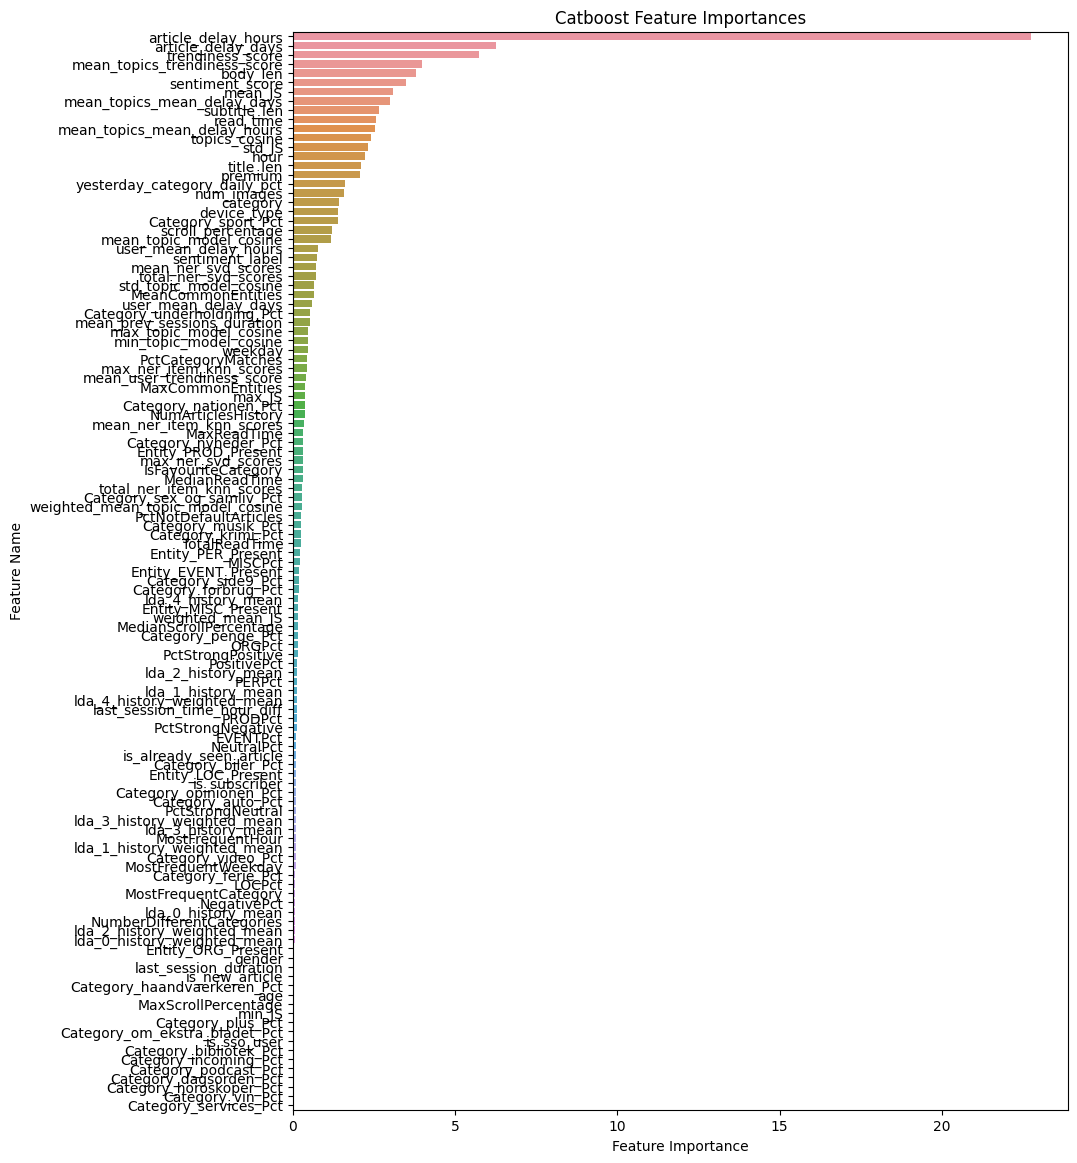

In [40]:
sorted_importances = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 14))
sns.barplot(x=feature_importances[sorted_importances], y=np.array(X.columns)[sorted_importances])
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Catboost Feature Importances')

In [41]:
del history_train
del behaviors_train

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)


RAM memory GB usage = 4.169


In [42]:
model.get_param('cat_features')

['device_type',
 'is_sso_user',
 'gender',
 'is_subscriber',
 'weekday',
 'premium',
 'category',
 'sentiment_label',
 'is_new_article',
 'is_already_seen_article',
 'MostFrequentCategory',
 'MostFrequentWeekday',
 'IsFavouriteCategory',
 'Entity_EVENT_Present',
 'Entity_ORG_Present',
 'Entity_LOC_Present',
 'Entity_PER_Present',
 'Entity_PROD_Present',
 'Entity_MISC_Present']

# Model Evaluation

In [43]:
user_id_mapping = history_val.sort('user_id').with_row_index() \
    .select(['index', 'user_id']).rename({'index': 'user_index'})

ner_interactions = history_val.select(['user_id', 'article_id_fixed']).explode('article_id_fixed') \
    .join(articles.select(['article_id', 'ner_clusters']), left_on='article_id_fixed', right_on='article_id', how='left') \
    .explode('ner_clusters').unique(['user_id', 'ner_clusters']) \
    .with_columns(pl.col('ner_clusters').str.strip_chars_start('\" ').str.to_lowercase()) \
    .join(user_id_mapping, on='user_id', how='left') \
    .join(ner_mapping, left_on='ner_clusters', right_on='ner') \
    .select(['user_index', 'ner_index', 'user_id', 'article_id_fixed']) \
    .unique(['user_index', 'ner_index'])

URM_ner = sps.csr_matrix((np.ones(ner_interactions.shape[0]),
                          (ner_interactions['user_index'].to_numpy(), ner_interactions['ner_index'].to_numpy())),
                         shape=(user_id_mapping.shape[0], ner_mapping.shape[0]))

ner_interactions_test = behaviors_val.select(['user_id', 'article_ids_clicked']).explode('article_ids_clicked') \
    .join(articles.select(['article_id', 'ner_clusters']), left_on='article_ids_clicked', right_on='article_id', how='left') \
    .explode('ner_clusters').unique(['user_id', 'ner_clusters']) \
    .with_columns(pl.col('ner_clusters').str.strip_chars_start('\" ').str.to_lowercase()) \
    .join(user_id_mapping, on='user_id', how='left') \
    .join(ner_mapping, left_on='ner_clusters', right_on='ner') \
    .select(['user_index', 'ner_index', 'user_id', 'article_ids_clicked']) \
    .unique(['user_index', 'ner_index'])

URM_ner_test = sps.csr_matrix((np.ones(ner_interactions_test.shape[0]),
                               (ner_interactions_test['user_index'].to_numpy(), ner_interactions_test['ner_index'].to_numpy())),
                              shape=(user_id_mapping.shape[0], ner_mapping.shape[0]))

In [44]:
item_knn = ItemKNNCFRecommender(URM_ner)
item_knn.fit(topK=100, similarity='jaccard')

evaluator = EvaluatorHoldout(URM_ner_test, cutoff_list=[10], exclude_seen=False)
result_df, _ = evaluator.evaluateRecommender(item_knn)
result_df

ItemKNNCFRecommender: URM Detected 3 ( 0.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 19035 (43.5%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 43774 (100.0%), 165.53 column/sec. Elapsed time 4.41 min
EvaluatorHoldout: Ignoring 32 ( 0.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 15310 (100.0%) in 47.11 sec. Users per second: 325


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.338445,0.339461,0.033197,0.241643,0.241977,0.493913,0.346767,0.060464,0.784651,1.033204,...,0.997914,0.783014,0.997914,0.002568,5.473111,0.953841,0.020621,0.428217,3.43338,0.010093


In [45]:
pure_svd = PureSVDRecommender(URM_ner)
pure_svd.fit(num_factors=20)

result_df, _ = evaluator.evaluateRecommender(pure_svd)
result_df

PureSVDRecommender: URM Detected 3 ( 0.0%) users with no interactions.
PureSVDRecommender: URM Detected 19035 (43.5%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 4.58 sec
EvaluatorHoldout: Processed 15310 (100.0%) in 25.01 sec. Users per second: 612


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.365382,0.368539,0.050795,0.283615,0.285707,0.695447,0.415659,0.089191,0.876486,1.342637,...,0.997914,0.874658,0.997914,0.001527,5.728555,0.954883,0.012263,0.448203,3.536612,0.010003


In [46]:
%%time

def get_inview_scores(user_ners_df, recommender, f_name):
    user_index = user_ners_df['user_index'].to_list()[0]
    ners = user_ners_df['ner_index'].to_numpy()
    scores = recommender._compute_item_score([user_index], ners)[0, ners]
    return user_ners_df.with_columns(
        pl.Series(scores).alias(f_name)
    )

ner_inview_scores = behaviors_val.select(['user_id', 'article_ids_inview']).explode('article_ids_inview') \
    .join(articles.select(['article_id', 'ner_clusters']), left_on='article_ids_inview', right_on='article_id', how='left') \
    .explode('ner_clusters').unique(['user_id', 'ner_clusters']) \
    .with_columns(pl.col('ner_clusters').str.strip_chars_start('\" ').str.to_lowercase()) \
    .join(user_id_mapping, on='user_id', how='left') \
    .join(ner_mapping, left_on='ner_clusters', right_on='ner') \
    .select(['user_index', 'ner_index', 'user_id', 'article_ids_inview']) \
    .unique(['user_index', 'ner_index']) \
    .sort(['user_index', 'ner_index']).group_by('user_index').map_groups(
        lambda user_df: user_df.pipe(get_inview_scores, recommender=pure_svd, f_name='pure_svd_scores') \
            .pipe(get_inview_scores, recommender=item_knn, f_name='item_knn_scores')
    )

behaviors_ner_scores = behaviors_val.select(['impression_id', 'user_id', 'article_ids_inview']).explode('article_ids_inview') \
    .join(ner_inview_scores, on=['user_id', 'article_ids_inview'], how='left') \
    .with_columns(pl.col(['pure_svd_scores', 'item_knn_scores']).fill_null(0)) \
    .group_by(['impression_id', 'article_ids_inview']).agg(
        pl.col('pure_svd_scores').sum().alias('total_ner_svd_scores'),
        pl.col('pure_svd_scores').mean().alias('mean_ner_svd_scores'),
        pl.col('pure_svd_scores').max().alias('max_ner_svd_scores'),
        pl.col('item_knn_scores').sum().alias('total_ner_item_knn_scores'),
        pl.col('item_knn_scores').mean().alias('mean_ner_item_knn_scores'),
        pl.col('item_knn_scores').max().alias('max_ner_item_knn_scores'),
    ).with_columns(
        pl.col(['total_ner_svd_scores', 'mean_ner_svd_scores', 
                'total_ner_item_knn_scores', 'mean_ner_item_knn_scores',
                'max_ner_svd_scores', 'max_ner_item_knn_scores']).sum().over('impression_id').name.suffix('_max')
    ).with_columns(
        # l1 normalization
        pl.col('total_ner_svd_scores').truediv(pl.col('total_ner_svd_scores_max')),
        pl.col('mean_ner_svd_scores').truediv(pl.col('mean_ner_svd_scores_max')),
        pl.col('max_ner_svd_scores').truediv(pl.col('max_ner_svd_scores_max')),
        pl.col('total_ner_item_knn_scores').truediv(pl.col('total_ner_item_knn_scores_max')),
        pl.col('mean_ner_item_knn_scores').truediv(pl.col('mean_ner_item_knn_scores_max')),
        pl.col('max_ner_item_knn_scores').truediv(pl.col('max_ner_item_knn_scores_max')),
    ).drop(['total_ner_svd_scores_max', 'mean_ner_svd_scores_max', 
            'max_ner_svd_scores_max', 'total_ner_item_knn_scores_max',
            'mean_ner_item_knn_scores_max', 'max_ner_item_knn_scores_max']) \
    .rename({'article_ids_inview': 'article'})
behaviors_ner_scores.head(5)

CPU times: user 4min 38s, sys: 3min 13s, total: 7min 51s
Wall time: 2min 10s


impression_id,article,total_ner_svd_scores,mean_ner_svd_scores,max_ner_svd_scores,total_ner_item_knn_scores,mean_ner_item_knn_scores,max_ner_item_knn_scores
u32,i32,f32,f32,f32,f32,f32,f32
96791,9783865,0.065138,0.042019,0.099119,0.042012,0.02688,0.089325
96791,9784679,0.198,0.218959,0.192213,0.221395,0.242829,0.204195
96798,9782726,0.111075,0.075559,0.072855,0.109575,0.076234,0.063155
96798,9782806,0.035775,0.035152,0.067555,0.039551,0.039746,0.06276
96798,9779370,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
model.get_param('cat_features')

['device_type',
 'is_sso_user',
 'gender',
 'is_subscriber',
 'weekday',
 'premium',
 'category',
 'sentiment_label',
 'is_new_article',
 'is_already_seen_article',
 'MostFrequentCategory',
 'MostFrequentWeekday',
 'IsFavouriteCategory',
 'Entity_EVENT_Present',
 'Entity_ORG_Present',
 'Entity_LOC_Present',
 'Entity_PER_Present',
 'Entity_PROD_Present',
 'Entity_MISC_Present']

In [48]:
%%time

STRONG_THR = 0.8

history_val = pl.concat(
    rows.with_columns(pl.col('article_id_fixed').list.len().alias('NumArticlesHistory')) \
        .explode(['article_id_fixed', 'impression_time_fixed', 'read_time_fixed', 'scroll_percentage_fixed']) \
        .sort(by=['user_id', 'impression_time_fixed']) \
        .with_columns(
            pl.col('impression_time_fixed').dt.weekday().alias('weekday'),
            pl.col('impression_time_fixed').dt.hour().alias('hour'),
        ).join(articles.select(['article_id', 'category', 'is_article_default', 'sentiment_label_int', 
                                'sentiment_score', 'entity_groups', 'topics']), 
               left_on='article_id_fixed', right_on='article_id', how='left') \
        .with_columns(
            (pl.col('sentiment_label_int') == 0).alias('is_neutral'),
            (pl.col('sentiment_label_int') == 1).alias('is_positive'),
            (pl.col('sentiment_label_int') == -1).alias('is_negative'),
            ((pl.col('sentiment_label_int') == 0) & (pl.col('sentiment_score') > STRONG_THR)).alias('strong_neutral'),
            ((pl.col('sentiment_label_int') == 1) & (pl.col('sentiment_score') > STRONG_THR)).alias('strong_positive'),
            ((pl.col('sentiment_label_int') == -1) & (pl.col('sentiment_score') > STRONG_THR)).alias('strong_negative'),
            pl.col('entity_groups').list.unique(),
        ).group_by('user_id').agg(
            pl.col('article_id_fixed'),
            pl.col('impression_time_fixed'),
            pl.col('category'),
            pl.col('NumArticlesHistory').first(),
            pl.col('read_time_fixed').median().alias('MedianReadTime'),
            pl.col('read_time_fixed').max().alias('MaxReadTime'),
            pl.col('read_time_fixed').sum().alias('TotalReadTime'),
            pl.col('scroll_percentage_fixed').median().alias('MedianScrollPercentage'),
            pl.col('scroll_percentage_fixed').max().alias('MaxScrollPercentage'),
            (pl.col('is_neutral').sum() / pl.col('NumArticlesHistory').first()).alias('NeutralPct'),
            (pl.col('is_positive').sum() / pl.col('NumArticlesHistory').first()).alias('PositivePct'),
            (pl.col('is_negative').sum() / pl.col('NumArticlesHistory').first()).alias('NegativePct'),
            (pl.col('strong_neutral').sum() / pl.col('NumArticlesHistory').first()).alias('PctStrongNeutral'),
            (pl.col('strong_positive').sum() / pl.col('NumArticlesHistory').first()).alias('PctStrongPositive'),
            (pl.col('strong_negative').sum() / pl.col('NumArticlesHistory').first()).alias('PctStrongNegative'),
            (1 - (pl.col('is_article_default').sum() / pl.col('NumArticlesHistory').first())).alias('PctNotDefaultArticles'),
            pl.col('category').mode().alias('MostFrequentCategory'),
            pl.col('weekday').mode().alias('MostFrequentWeekday'),
            pl.col('hour').mode().alias('MostFrequentHour'),
            pl.col('entity_groups').flatten(),
            pl.col('topics').flatten().alias('topics_flatten')
        ).pipe(add_topics_tf_idf_columns, topics_col='topics_flatten', vectorizer=vectorizer) \
        .drop('topics_flatten').with_columns(
            pl.col('MostFrequentCategory').list.first(),
            pl.col('MostFrequentWeekday').list.first(),
            pl.col('MostFrequentHour').list.first(),
        ).with_columns(
            (pl.col('entity_groups').list.count_matches(entity) / pl.col('NumArticlesHistory')).alias(f'{entity}Pct')
            for entity in unique_entities
        ).drop('entity_groups')
    for rows in tqdm.tqdm(history_val.iter_slices(1000), total=history_val.shape[0] // 1000)
)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
history_val = reduce_polars_df_memory_size(history_val)
history_val.head(2)

16it [00:16,  1.04s/it]                        



RAM memory GB usage = 4.592
Memory usage of dataframe is 36.51 MB
Memory usage after optimization is: 35.72 MB
Decreased by 2.2%
CPU times: user 19.4 s, sys: 1.7 s, total: 21.1 s
Wall time: 17.5 s


user_id,article_id_fixed,impression_time_fixed,category,NumArticlesHistory,MedianReadTime,MaxReadTime,TotalReadTime,MedianScrollPercentage,MaxScrollPercentage,NeutralPct,PositivePct,NegativePct,PctStrongNeutral,PctStrongPositive,PctStrongNegative,PctNotDefaultArticles,MostFrequentCategory,MostFrequentWeekday,MostFrequentHour,topics_flatten_tf_idf,EVENTPct,ORGPct,LOCPct,PERPct,PRODPct,MISCPct
u32,list[i32],list[datetime[μs]],list[i16],u16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i8,i8,list[f32],f32,f32,f32,f32,f32,f32
10623,"[9750749, 9685790, … 9779517]","[2023-05-05 07:51:01, 2023-05-05 07:51:36, … 2023-05-24 17:10:11]","[118, 457, … 414]",150,3.5,1563.0,9330.0,37.0,100.0,0.28,0.093333,0.626667,0.126667,0.06,0.546667,0.06,118,1,20,"[0.0, 0.042172, … 0.089681]",0.3,0.913333,0.846667,0.893333,0.213333,0.266667
12718,"[9749036, 9749025, … 9778718]","[2023-05-04 07:49:49, 2023-05-04 07:50:15, … 2023-05-24 07:07:25]","[118, 118, … 140]",114,7.0,748.0,3440.0,36.0,100.0,0.245614,0.052632,0.701754,0.087719,0.035088,0.614035,0.035088,118,7,7,"[0.0, 0.048524, … 0.217846]",0.114035,0.947368,0.815789,0.807018,0.254386,0.192982


In [49]:
last_history_df = history_val.with_columns(
    pl.col('impression_time_fixed').list.max().alias('last_history_impression_time'),
    pl.col('article_id_fixed').list.tail(1).alias('last_history_article'),
).select(['user_id', 'last_history_impression_time', 'last_history_article'])

last_session_time_df = behaviors_val.select(['session_id', 'user_id', 'impression_time', 'article_ids_inview', 'article_ids_clicked']) \
    .group_by('session_id').agg(
        pl.col('user_id').first(), 
        pl.col('impression_time').max().alias('session_time'), 
        pl.col('article_ids_inview').flatten().alias('all_seen_articles'),
        (pl.col('impression_time').max() - pl.col('impression_time').min()).dt.total_minutes().alias('session_duration'),
    ).with_columns(
        pl.col(['session_time', 'session_duration']).shift(1).over('user_id').name.prefix('last_'),
        pl.col('all_seen_articles').list.unique().shift(1).over('user_id'),
        pl.col('session_duration').rolling_mean(100, min_periods=1).over('user_id').alias('mean_prev_sessions_duration'),
    ).with_columns(pl.col(['last_session_duration']).fill_null(0)) \
    .join(last_history_df, on='user_id', how='left') \
    .with_columns(
        pl.col('last_session_time').fill_null(pl.col('last_history_impression_time')),
        pl.col('all_seen_articles').fill_null(pl.col('last_history_article')),
    ).select(['session_id', 'last_session_time', 'last_session_duration',
              'all_seen_articles', 'mean_prev_sessions_duration'])

In [50]:
%%time

NPRATIO = 2

# dropping duplicates that can occur because of sampling strategy
val_ds = behaviors_val.pipe(create_binary_labels_column, shuffle=True, seed=123) \
    .with_columns(pl.col('gender').fill_null(2)) \
    .select(['impression_id', 'article_ids_inview', 'impression_time', 'labels', 
             'device_type', 'read_time', 'scroll_percentage', 'user_id', 'is_sso_user', 'gender',
             'age', 'is_subscriber', 'session_id']) \
    .explode(['article_ids_inview', 'labels']) \
    .rename({'article_ids_inview': 'article', 'labels': 'target'}) \
    .with_columns(pl.col('article').cast(pl.Int32)) \
    .pipe(add_mean_delays_features, articles=articles, history=history_val) \
    .pipe(add_trendiness_feature, articles=articles, period='3d') \
    .pipe(add_history_trendiness_scores_feature, history=history_val, articles=articles) \
    .unique(['impression_id', 'article']) \
    .with_columns(
        pl.col('impression_time').dt.weekday().alias('weekday'),
        pl.col('impression_time').dt.hour().alias('hour'),
        pl.col('article').cast(pl.Int32),
    ).join(articles.select(['article_id', 'premium', 'published_time', 'category',
                            'sentiment_score', 'sentiment_label', 'entity_groups',
                            'num_images', 'title_len', 'subtitle_len', 'body_len']),
           left_on='article', right_on='article_id', how='left') \
    .with_columns(
        (pl.col('impression_time') - pl.col('published_time')).dt.total_days().alias('article_delay_days'),
        (pl.col('impression_time') - pl.col('published_time')).dt.total_hours().alias('article_delay_hours')
    ).with_columns(
        pl.col('entity_groups').list.contains(entity).alias(f'Entity_{entity}_Present')
        for entity in unique_entities
    ).drop('entity_groups') \
    .join(last_session_time_df, on='session_id', how='left').with_columns(
        (pl.col('impression_time') - pl.col('last_session_time')).dt.total_hours().alias('last_session_time_hour_diff'),
        ((pl.col('last_session_time') - pl.col('published_time')).dt.total_hours() > 0).alias('is_new_article'),
        pl.col('all_seen_articles').list.contains(pl.col('article')).alias('is_already_seen_article'),
    ).drop(['published_time', 'session_id', 'all_seen_articles', 'last_session_time']) \
    .join(published_category_popularity, how='left', right_on=['published_date', 'category'],
          left_on=[pl.col('impression_time').dt.date() - pl.duration(days=1), 'category']) \
    .rename({'category_daily_pct': 'yesterday_category_daily_pct'}) \
    .with_columns(pl.col('yesterday_category_daily_pct').fill_null(0)) \
    .join(behaviors_ner_scores, on=['impression_id', 'article'], how='left')

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)

val_ds = reduce_polars_df_memory_size(val_ds)
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
val_ds.head()


RAM memory GB usage = 5.914
Memory usage of dataframe is 530.72 MB
Memory usage after optimization is: 360.33 MB
Decreased by 32.1%

RAM memory GB usage = 5.721
CPU times: user 10min 7s, sys: 33.2 s, total: 10min 40s
Wall time: 3min 7s


impression_id,article,user_id,impression_time,target,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,mean_topics_mean_delay_days,mean_topics_mean_delay_hours,user_mean_delay_days,user_mean_delay_hours,trendiness_score,mean_user_trendiness_score,mean_topics_trendiness_score,weekday,hour,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,article_delay_days,article_delay_hours,Entity_EVENT_Present,Entity_ORG_Present,Entity_LOC_Present,Entity_PER_Present,Entity_PROD_Present,Entity_MISC_Present,last_session_duration,mean_prev_sessions_duration,last_session_time_hour_diff,is_new_article,is_already_seen_article,yesterday_category_daily_pct,total_ner_svd_scores,mean_ner_svd_scores,max_ner_svd_scores,total_ner_item_knn_scores,mean_ner_item_knn_scores,max_ner_item_knn_scores
u32,i32,u32,date,i8,i8,f32,f32,bool,i8,i8,bool,f32,f32,f32,f32,i16,f32,f32,i8,i8,bool,i16,f32,str,u32,u8,u8,u16,i16,i32,bool,bool,bool,bool,bool,bool,i8,f32,i16,bool,bool,f32,f32,f32,f32,f32,f32,f32
96798,9784489,22548,2023-05-27,0,2,46.0,null,false,2,null,false,4.118936,101.51181,0.023077,2.846154,407,224.653839,372.922729,7,4,false,142,0.7287,"""Neutral""",3,5,35,447,0,10,false,true,true,true,true,true,17,8.5,-71,true,false,0.357143,-0.01515,-0.007881,0.02264,0.044049,0.023435,0.023035
96798,9777026,22548,2023-05-27,0,2,46.0,null,false,2,null,false,14.008358,339.097809,0.023077,2.846154,336,224.653839,290.947235,7,4,false,414,0.5496,"""Neutral""",2,9,16,225,4,114,true,true,true,true,true,false,17,8.5,-71,true,false,0.107143,-0.012665,-0.012444,0.000038,0.036378,0.036557,0.020279
96818,9784710,22548,2023-05-27,0,2,6.0,null,false,2,null,false,5.399225,132.029892,0.023077,2.846154,465,224.653839,362.710724,7,4,false,142,0.8887,"""Positive""",2,8,5,201,0,6,false,true,true,true,false,false,2,5.3,-64,true,false,0.357143,0.189449,0.17993,0.231078,0.202137,0.189684,0.216801
96821,9784575,22548,2023-05-27,0,2,43.0,null,false,2,null,false,18.391716,444.412628,0.023077,2.846154,217,224.653839,258.222717,7,4,false,414,0.9949,"""Negative""",1,7,25,285,0,9,false,true,false,true,true,false,17,8.5,-71,true,false,0.107143,0.024311,0.027933,0.018781,0.01452,0.016801,0.011983
99431,9784804,32455,2023-05-27,0,2,134.0,100.0,false,2,null,false,5.697979,139.346649,0.0,1.177419,197,191.1129,257.539276,7,4,false,118,0.9378,"""Neutral""",1,9,17,383,0,0,false,true,true,true,true,false,0,0.333333,-4,true,false,0.276786,0.365459,0.306859,0.253495,0.329987,0.282119,0.19996


In [51]:
val_ds.shape

(2928942, 49)

In [52]:
prev_columns = [c for c in val_ds.columns if c not in ['impression_id', 'article', 'impression_time']]

val_ds = pl.concat(
    rows.join(history_val.select(['user_id', 'article_id_fixed', 'impression_time_fixed']), on='user_id', how='left') \
        .join(articles.select(['article_id', 'topics', 'entity_groups', 'topics_idf'] + topic_model_columns), 
              left_on='article', right_on='article_id', how='left') \
        .explode(['article_id_fixed', 'impression_time_fixed']) \
        .join(articles.select(['article_id', 'topics', 'entity_groups'] + topic_model_columns), 
              left_on='article_id_fixed', right_on='article_id', how='left') \
        .rename({'topics_right': 'topics_history', 'entity_groups_right': 'entity_groups_history'}) \
        .rename({f'topic_model_embedding_{i}_right': f'topic_model_embedding_{i}_history' for i in range(N_COMPONENTS)}) \
        .with_columns(
            # 1/delay gives the weight for the weighted mean of the lda embeddings
            (1 / (pl.col('impression_time') - pl.col('impression_time_fixed')).dt.total_hours()).alias('history_weight'),
            (pl.col("topics").list.set_intersection(pl.col("topics_history")).list.len().truediv(
                pl.col("topics").list.set_union(pl.col("topics_history")).list.len()
            )).alias("JS"),
            pl.col('entity_groups').list.set_intersection(pl.col('entity_groups_history')).list.len().alias('common_entities'),
        ).drop(['entity_groups_history', 'entity_groups', 'topics', 'topics_history']) \
        .with_columns(
            # summing delays to normalize them before weighted mean
            pl.col('history_weight').sum().over(['impression_id', 'article']).alias('history_weight_sum'),
            *[pl.col(x).mul(pl.col(f'{x}_history')).alias(f'{x}_dot') for x in topic_model_columns],
            *[pl.col(x).mul(pl.col(x)) for x in topic_model_columns],
            *[pl.col(f'{x}_history').mul(pl.col(f'{x}_history')).alias(f'{x}_history_square') for x in topic_model_columns],
        ).with_columns(
            # weights now sum to 1
            pl.col('history_weight').truediv(pl.col('history_weight_sum')),
            pl.sum_horizontal(topic_model_columns).sqrt().alias('topic_model_norm'),
            pl.sum_horizontal([f'{x}_history_square' for x in topic_model_columns]).sqrt().alias('topic_model_history_norm'),
            pl.sum_horizontal([f'{x}_dot' for x in topic_model_columns]).alias('topic_model_dot'),
        ).with_columns(
            *[pl.col(f'{x}_history').mul(pl.col('history_weight')).alias(f'{x}_history_weighted') for i, x in enumerate(topic_model_columns)],
            pl.col('topic_model_dot').truediv(pl.col('topic_model_norm').mul('topic_model_history_norm')).alias('topic_model_cosine')
        ).group_by(['impression_id', 'article']).agg(
            pl.col(prev_train_columns).first(),
            pl.col('topics_idf').first(),
            pl.col('common_entities').mean().alias('MeanCommonEntities'),
            pl.col('common_entities').max().alias('MaxCommonEntities'),
            pl.col("JS").mean().alias("mean_JS"),
            pl.col("JS").min().alias("min_JS"),
            pl.col("JS").max().alias("max_JS"),
            pl.col("JS").std().alias("std_JS"),
            pl.col("JS").mul(pl.col("history_weight")).sum().alias("weighted_mean_JS"),
            pl.col("topic_model_cosine").mean().alias("mean_topic_model_cosine"),
            pl.col("topic_model_cosine").min().alias("min_topic_model_cosine"),
            pl.col("topic_model_cosine").max().alias("max_topic_model_cosine"),
            pl.col("topic_model_cosine").std().alias("std_topic_model_cosine"),
            pl.col("topic_model_cosine").mul(pl.col("history_weight")).sum().alias("weighted_mean_topic_model_cosine"),
            *[pl.col(f'{x}_history').mean().alias(f'lda_{i}_history_mean') for i, x in enumerate(topic_model_columns)],
            *[pl.col(f'{x}_history_weighted').sum().alias(f'lda_{i}_history_weighted_mean') for i, x in enumerate(topic_model_columns)]
        ).join(history_val.drop(['article_id_fixed', 'impression_time_fixed']), on='user_id', how='left') \
        .with_columns(
            pl.struct(['topics_idf', 'topics_flatten_tf_idf']).map_elements(
                lambda x: cosine_similarity(x['topics_idf'], x['topics_flatten_tf_idf']), return_dtype=pl.Float64
            ).cast(pl.Float32).alias('topics_cosine'),
            (pl.col('category') == pl.col('MostFrequentCategory')).alias('IsFavouriteCategory'),
            pl.col('category_right').list.n_unique().alias('NumberDifferentCategories'),
            list_pct_matches_with_col('category_right', 'category').alias('PctCategoryMatches'),
        ).with_columns(
            [list_pct_matches_with_constant('category_right', c).alias(f'Category_{c_str}_Pct')
             for c, c_str in unique_categories.items()]
        ).drop(['topics_idf', 'topics_flatten', 'topics_flatten_tf_idf', 'category_right'])
    for rows in tqdm.tqdm(val_ds.iter_slices(10000), total=val_ds.shape[0] // 10000)
)

val_ds = reduce_polars_df_memory_size(val_ds)
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
val_ds.head()

293it [42:05,  8.62s/it]


Memory usage of dataframe is 1550.96 MB
Memory usage after optimization is: 1118.00 MB
Decreased by 27.9%

RAM memory GB usage = 7.737


impression_id,article,user_id,target,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,mean_topics_mean_delay_days,mean_topics_mean_delay_hours,user_mean_delay_days,user_mean_delay_hours,trendiness_score,mean_user_trendiness_score,mean_topics_trendiness_score,weekday,hour,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,article_delay_days,article_delay_hours,Entity_EVENT_Present,Entity_ORG_Present,Entity_LOC_Present,Entity_PER_Present,Entity_PROD_Present,Entity_MISC_Present,total_ner_svd_scores,…,MostFrequentWeekday,MostFrequentHour,EVENTPct,ORGPct,LOCPct,PERPct,PRODPct,MISCPct,topics_cosine,IsFavouriteCategory,NumberDifferentCategories,PctCategoryMatches,Category_side9_Pct,Category_bibliotek_Pct,Category_ferie_Pct,Category_underholdning_Pct,Category_penge_Pct,Category_krimi_Pct,Category_vin_Pct,Category_forbrug_Pct,Category_haandvaerkeren_Pct,Category_horoskoper_Pct,Category_dagsorden_Pct,Category_musik_Pct,Category_auto_Pct,Category_podcast_Pct,Category_plus_Pct,Category_services_Pct,Category_sport_Pct,Category_incoming_Pct,Category_biler_Pct,Category_om_ekstra_bladet_Pct,Category_opinionen_Pct,Category_nyheder_Pct,Category_video_Pct,Category_nationen_Pct,Category_sex_og_samliv_Pct
u32,i32,u32,i8,i8,f32,f32,bool,i8,i8,bool,f32,f32,f32,f32,i16,f32,f32,i8,i8,bool,i16,f32,str,u32,u8,u8,u16,i16,i32,bool,bool,bool,bool,bool,bool,f32,…,i8,i8,f32,f32,f32,f32,f32,f32,f32,bool,u8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
146878,9785828,84583,0,2,8.0,null,false,2,null,false,2.824303,70.13401,0.22871,8.63017,350,299.236023,393.217255,2,14,false,142,0.8393,"""Positive""",2,7,21,274,1,42,false,false,true,true,false,true,0.281503,…,6,10,0.3309,0.914842,0.788321,0.89781,0.270073,0.304136,0.719319,true,10,0.978102,0.0,0.0,0.002433,0.145985,0.002433,0.116788,0.0,0.009732,0.0,0.0,0.0,0.009732,0.0,0.0,0.0,0.0,0.501217,0.0,0.002433,0.0,0.0,0.189781,0.0,0.019465,0.0
147618,9785732,87032,0,1,13.0,null,false,2,null,false,4.118936,101.51181,0.0,2.68,483,152.880005,372.922729,2,14,false,142,0.8643,"""Neutral""",3,6,23,425,1,43,false,true,true,true,false,true,-0.003859,…,3,15,0.12,0.92,0.72,0.88,0.4,0.12,0.097573,false,7,0.76,0.0,0.0,0.0,0.28,0.08,0.12,0.0,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.0,0.0,0.4,0.0,0.04,0.0
196611,9777200,760890,0,2,18.0,null,false,2,null,false,4.460537,109.404533,36.209679,870.451599,391,220.145157,348.668915,6,19,true,142,0.9612,"""Neutral""",6,8,24,657,0,6,true,true,true,true,false,false,0.258348,…,3,18,0.225806,0.903226,0.758065,0.903226,0.387097,0.177419,0.288053,false,6,0.919355,0.0,0.0,0.0,0.322581,0.032258,0.225806,0.0,0.016129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.16129,0.0,0.0,0.0,0.0,0.241935,0.0,0.0,0.0
199016,9782763,769849,0,2,93.0,null,false,2,null,false,9.084131,220.870483,0.047826,4.26087,75,260.117401,271.363159,6,19,false,414,0.4785,"""Positive""",1,4,22,370,0,3,false,true,true,true,true,false,0.001089,…,2,6,0.321739,0.869565,0.778261,0.891304,0.252174,0.313043,0.161392,false,9,0.965217,0.004348,0.0,0.004348,0.182609,0.0,0.126087,0.0,0.013043,0.0,0.0,0.0,0.021739,0.0,0.0,0.0,0.0,0.404348,0.0,0.0,0.0,0.0,0.226087,0.0,0.017391,0.0
199149,9782656,770287,0,2,10.0,100.0,false,2,null,false,6.368984,155.472488,3.132948,77.236992,81,249.763,226.45549,6,19,false,457,0.7073,"""Neutral""",3,10,21,335,0,0,false,true,true,false,false,true,0.153348,…,3,19,0.312139,0.924855,0.83815,0.919075,0.277457,0.283237,0.061719,false,8,0.959538,0.0,0.0,0.0,0.179191,0.028902,0.115607,0.0,0.00578,0.0,0.0,0.0,0.034682,0.0,0.0,0.0,0.0,0.323699,0.0,0.0,0.0,0.0,0.277457,0.0,0.034682,0.0


In [53]:
del history_val
del articles
del behaviors_val

gc.collect()

0

In [54]:
val_ds.shape

(2928942, 121)

In [55]:
model.get_param('cat_features')

['device_type',
 'is_sso_user',
 'gender',
 'is_subscriber',
 'weekday',
 'premium',
 'category',
 'sentiment_label',
 'is_new_article',
 'is_already_seen_article',
 'MostFrequentCategory',
 'MostFrequentWeekday',
 'IsFavouriteCategory',
 'Entity_EVENT_Present',
 'Entity_ORG_Present',
 'Entity_LOC_Present',
 'Entity_PER_Present',
 'Entity_PROD_Present',
 'Entity_MISC_Present']

In [56]:
# impression_id will be later useful for evaluation
val_ds_pandas = val_ds.drop(['impression_id', 'article', 'user_id']).to_pandas()

val_ds_pandas[categorical_columns] = val_ds_pandas[categorical_columns].astype('category')

X_val = val_ds_pandas.drop(columns=['target'])
y_val = val_ds_pandas['target']

# doing model.predict_proba(...)[:, 1] to take only the probability of class 1
# while by doing [:, 0] we take the probability of class 0
val_ds = val_ds.with_columns(pl.Series(model.predict_proba(X_val)[:, 1]).alias('prediction'))
val_ds.select(['impression_id', 'target', 'prediction'])

impression_id,target,prediction
u32,i8,f64
146878,0,0.093819
147618,0,0.017742
196611,0,0.187928
199016,0,0.198976
199149,0,0.14842
…,…,…
579213206,0,0.261842
579233809,0,0.018124
579235287,0,0.134386


In [57]:
evaluation_ds = val_ds.group_by('impression_id').agg(pl.col('target'), pl.col('prediction'))
evaluation_ds

impression_id,target,prediction
u32,list[i8],list[f64]
130900018,"[0, 1, … 0]","[0.099595, 0.447015, … 0.147178]"
418820963,"[0, 0, … 0]","[0.104629, 0.230477, … 0.295625]"
357362931,"[1, 0, … 0]","[0.29553, 0.300345, … 0.423616]"
455137421,"[1, 0, … 0]","[0.452418, 0.159466, … 0.621414]"
314803788,"[0, 0, … 0]","[0.268214, 0.43958, … 0.079553]"
…,…,…
244817354,"[1, 0, … 0]","[0.480902, 0.009563, … 0.002478]"
72167846,"[1, 0, … 0]","[0.432018, 0.099918, … 0.541965]"
438176406,"[0, 0, … 0]","[0.276899, 0.523851, … 0.432531]"


In [58]:
%%time

met_eval = MetricEvaluator(
    labels=evaluation_ds['target'].to_list(),
    predictions=evaluation_ds['prediction'].to_list(),
    metric_functions=[
        AucScore(),
        MrrScore(),
        NdcgScore(k=5),
        NdcgScore(k=10),
    ],
)
met_eval.evaluate()

CPU times: user 6min 21s, sys: 829 ms, total: 6min 22s
Wall time: 6min 22s


<MetricEvaluator class>: 
 {
    "auc": 0.7196324495692942,
    "mrr": 0.4942469180283324,
    "ndcg@5": 0.5523772333559541,
    "ndcg@10": 0.5972616379356518
}